In [71]:
import pandas as pd
import pyarrow.parquet as pq
import os
import airportsdata 
from geopy.distance import geodesic

In [123]:
airports = airportsdata.load()

dataset = pq.ParquetDataset('c:\\Users\\lukas\\OneDrive - Imperial College London\\0_Sustainable Transport\\2021_COP26',
                            ) # filters=[('columnName', 'in', filterList)]
df = dataset.read(use_threads=True).to_pandas()

In [127]:
private_jet = ['CL60','P180','GLF5','GLEX','GLF6','F2TH','C17','LJ60','F900','GLF4','E35L','CL35','C30J','GL5T','ASTR','C130','BE20','H25B']
df = df[~df['aircraft_type_icao'].isin(private_jet)]
# df = df.drop(df[df['aircraft_type_icao'] == 'CL60'].index)
# df['aircraft_type_icao'].unique()
df

,callsign,icao_address,flight_number,tail_number,aircraft_type_icao,aircraft_engine_type,origin_airport,origin_airport_name,origin_country,destination_airport,...,so2_kg,sulphates_kg,nvpm_data_source,nvpm_mass_kg,nvpm_number,nvpm_ei_n_mean,sdr_mean,night_flight,night_segments,pct_night_dist
0,N831KB,AB5CF4,,N831KB,BE40,Jet,KDTO,Denton Municipal Airport,US,KADS,...,0.072813,0.001486,FA Model,0.000592,4.953908e+16,8.164379e+14,175.329813,False,False,0.0
2,N736MP,A9E276,,N736MP,C172,Piston,,,,,...,0.025976,0.000530,Constant,0.001905,2.164649e+16,1.000000e+15,18.714014,False,False,0.0
3,AVA9209,A4D7EB,AV9209,N411AV,A320,Jet,SKBO,El Dorado International Airport,CO,SKCL,...,1.660337,0.033884,ICAO EDB,0.069787,1.343395e+18,9.709314e+14,0.000000,True,True,100.0
4,N526ND,A6A068,,N526ND,C172,Piston,,,,,...,0.025405,0.000518,Constant,0.001863,2.117047e+16,1.000000e+15,203.507661,False,False,0.0
5,RYR96,4CA645,FR5394,EI-DYC,B738,Jet,,,,LIME,...,1.613571,0.032930,ICAO EDB,0.051059,1.184296e+18,8.807518e+14,0.000000,True,True,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6299248,CCA8221,781588,CA8221,B-304F,A320,Jet,ZHHH,Wuhan Tianhe International Airport,CN,ZUUU,...,4.517517,0.092194,ICAO EDB,0.178838,4.219963e+18,1.120960e+15,211.502269,False,False,0.0
6299249,DAL8845,A8BBFF,DL8845,N662DN,B752,Jet,KSNA,John Wayne Airport-Orange County Airport,US,KSMF,...,4.275811,0.087261,FA Model,0.570083,5.294014e+18,1.485757e+15,167.638766,False,False,0.0
6299250,N429MR,A51E31,,N429MR,C25C,Jet,KSUX,Sioux Gateway Airport / Brigadier General Bud ...,US,KDBQ,...,0.461343,0.009415,Constant,0.033832,3.844525e+17,1.000000e+15,0.000852,True,True,100.0
6299251,CSH9511,780F8F,FM9511,B-7862,B738,Jet,ZHCC,Zhengzhou Xinzheng International Airport,CN,ZYCC,...,5.721083,0.116757,ICAO EDB,0.228237,5.338755e+18,1.119807e+15,258.416273,False,False,0.0


In [128]:
delegates_path = os.getcwd() + '\\origin_airports_delegates.csv'
data_delegates = pd.read_csv(delegates_path)

iata_icao_path = os.getcwd() + '\\iata-icao.csv'
data_iata_icao = pd.read_csv(iata_icao_path)

In [129]:
airport_location = data_delegates.merge(data_iata_icao, on='iata', how='left')[['iata','icao','total_delegates','country_code','airport','latitude','longitude']]
# airport_location


In [130]:
# Check for NAN values 
# airport_location.isna()
# airport_location = airport_location.dropna()#isna().sum()#.any(axis=1).count
# airport_location[airport_location.isna().any(axis=1)]
airport_location["country_code"][77] =  "NA"

In [131]:
dubai_airport = pd.DataFrame({'latitude_A': [airports.get('OMDB')['lat']],
                     'longitude_A': [airports.get('OMDB')['lon']]})

delegate_airports = airport_location[['latitude','longitude']]

# Function to calculate distance using geopy.distance
def calculate_distance(row):
    coord_A = (dubai_airport['latitude_A'].iloc[0], dubai_airport['longitude_A'].iloc[0])
    coord_B = (row['latitude'], row['longitude'])
    return geodesic(coord_A, coord_B).kilometers

airport_location['distance_to_dubai'] = delegate_airports.apply(calculate_distance,axis=1)

airport_location

,iata,icao,total_delegates,country_code,airport,latitude,longitude,distance_to_dubai
0,AUH,OMAA,4409,AE,Abu Dhabi International Airport,24.43300,54.65110,115.950398
1,GRU,SBGR,7598,BR,Sao Paulo/Guarulhos International Airport,-23.42620,-46.48000,12218.280093
2,PEK,ZBAA,3480,CN,Beijing Capital International Airport,40.07250,116.59800,5856.254969
3,LOS,DNMM,1411,NG,Murtala Muhammed International Airport,6.57737,3.32116,5899.623220
4,CGK,WIII,1229,ID,Soekarno–Hatta International Airport,-6.12556,106.65600,6543.695620
...,...,...,...,...,...,...,...,...
202,ZRH,LSZH,8,CH,Zurich Airport,47.46470,8.54917,4773.283197
203,KIV,LUKK,8,MD,Chisinau International Airport,46.92770,28.93100,3352.541593
204,ASM,HHAS,7,ER,Asmara International Airport,15.29190,38.91070,2039.020269
205,MGA,MNMG,6,NI,Augusto C. Sandino International Airport,12.14150,-86.16820,14143.820362


In [132]:
airport_location[airport_location['distance_to_dubai'] >= 10000]

,iata,icao,total_delegates,country_code,airport,latitude,longitude,distance_to_dubai
1,GRU,SBGR,7598,BR,Sao Paulo/Guarulhos International Airport,-23.426200,-46.4800,12218.280093
10,JFK,KJFK,1899,US,John F. Kennedy International Airport,40.639700,-73.7789,11021.839311
13,YOW,CYOW,1830,CA,Ottawa Macdonald-Cartier International Airport,45.322500,-75.6692,10756.579780
32,SYD,YSSY,996,AU,Sydney Airport (Kingsford Smith Airport),-33.946100,151.1770,12038.861443
37,BOG,SKBO,932,CO,El Dorado International Airport,4.701590,-74.1469,13645.133727
45,SCL,SCEL,742,CL,Comodoro Arturo Merino Benitez International A...,-33.393000,-70.7858,14776.568263
46,SCL,SCEL,742,CL,Arturo Merino Benítez International Airport,-33.392800,-70.7856,14776.547899
80,LIM,SPIM,195,PE,Jorge Chavez International Airport,-12.021900,-77.1143,14836.731110
90,AEP,SABE,179,AR,Aeroparque Internacional Jorge Newbery,-34.558900,-58.4164,13659.050933
105,TGU,MHTG,139,HN,Toncontin International Airport,14.060900,-87.2172,14069.337152


In [133]:
print(airport_location[airport_location['distance_to_dubai'] >= 10000]['distance_to_dubai'].count(),"flights with over 10,000 km")

55 flights with over 10,000 km


In [134]:
print("Total km flown to COP28:",round(sum(airport_location['distance_to_dubai']),0))
print("Total Delegates:          ",sum(airport_location.total_delegates))

Total km flown to COP28: 1401384.0
Total Delegates:           81939


# Calculating CO2 emissions with take-off and landing (non-transit)

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pycountry
import pycountry_convert as pc

In [136]:
def country_code_to_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except AttributeError:
        return None

plot_data = airport_location[:][:40]
plot_data
plot_data['country_name'] = plot_data['country_code'].apply(country_code_to_name)

In [137]:
plot_data.loc[0,"country_name"] = 'UAE'
plot_data.loc[12,"country_name"] = 'Tanzania'
plot_data.loc[17,"country_name"] = 'Korea'
plot_data.loc[20,"country_name"] = 'Congo'
plot_data.loc[21,"country_name"] = 'Russia'

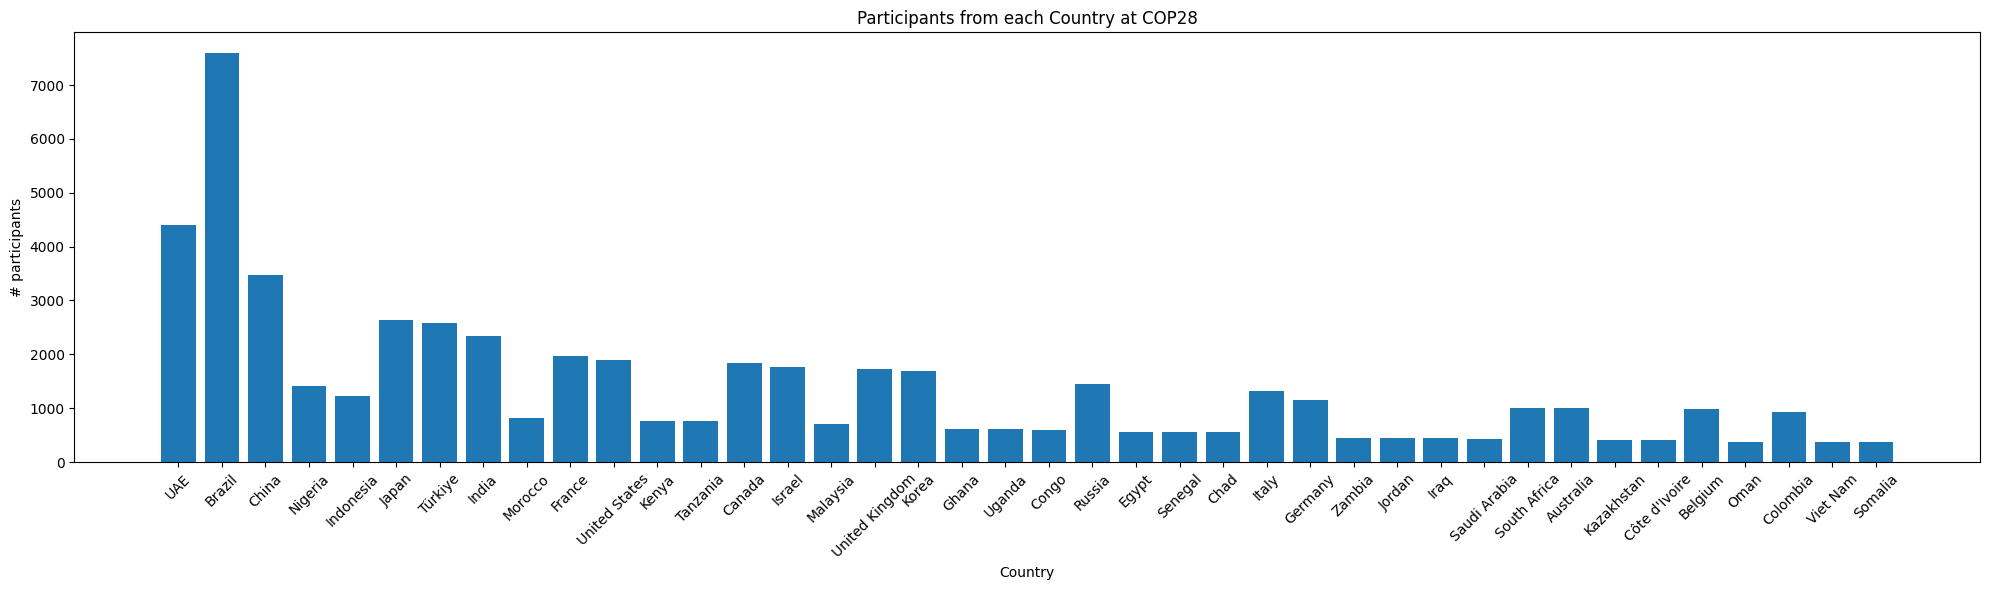

In [138]:

# Plot the data
plt.figure(figsize=(20, 6))  # Set the figure size
plt.bar(plot_data['country_name'], plot_data.total_delegates)  # Plot a bar chart
plt.title('Participants from each Country at COP28')  # Set the title
plt.xlabel('Country')  # Set the x-axis label
plt.ylabel('# participants')  # Set the y-axis label
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.savefig('participants_country.pdf')
plt.show()  # Show the plot

In [139]:
import plotly.io as pio

sorted_indices = sorted(range(len(plot_data['total_delegates'])), key=lambda i: plot_data['total_delegates'][i])
sorted_categories = [plot_data['country_name'][i] for i in sorted_indices]
sorted_values = [plot_data['total_delegates'][i] for i in sorted_indices]

fig = go.Figure(data=[go.Bar(
    y=sorted_categories,  # y-axis categories
    x=sorted_values,      # x-axis values
    orientation='h'  # horizontal orientation
)])

# Add title and labels
fig.update_layout(
    title='Participants from each country (Top 40)',
    yaxis=dict(title='Countries'),
    xaxis=dict(title='# participants'),
    width=400,
    height=800
)

# Show the chart
#fig.write_image("participants_country.png")
fig.show()
#pio.write_image(fig, "participants_country.png")


### Checking if flight from origin to destination is in flight database

In [140]:
destination_dubai = df[df['destination_airport'] == 'OMDB']
# destination_dubai[destination_dubai['origin_airport'] == 'DNMM'] #[['origin_airport_name','destination_airport_name']]
# destination_dubai['origin_airport'] = destination_dubai['origin_airport'].astype('str')#.dtypes
# destination_dubai['origin_airport'].unique()


In [141]:
# # Alternative 
# def inner_merge_on_columns(df1, df2, column1, column2):
#     merged_data = []
#     for value1 in df1[column1]:
#         for value2 in df2[column2]:
#             if value1 == value2:
#                 row1 = df1[df1[column1] == value1].iloc[0].to_dict()
#                 row2 = df2[df2[column2] == value2].iloc[0].to_dict()
#                 merged_data.append({**row1, **row2})
#     return pd.DataFrame(merged_data)

# merged_df = inner_merge_on_columns(airport_location,destination_dubai,"icao","origin_airport")
# merged_df['icao'].unique()


# Merging airport origin with the existing flights from 2021
merged_df = airport_location.merge(destination_dubai, left_on='icao', right_on='origin_airport', how='inner')
test = merged_df['icao'].unique()
test.size

87

##### Select unique flights from origin to destination airport

In [142]:

unique_flights_df = merged_df.drop_duplicates(subset=['icao'])
unique_flights_df.reset_index(inplace=True)

# Relevant columns
unique_flights_df = unique_flights_df[['icao', 'total_delegates', 'country_code', 'origin_airport','destination_airport',
       'distance_to_dubai', 'assumed_load_factor', 'aircraft_type_icao', 'total_fuel_burn','co2_kg', 
       'nox_kg','hc_kg', 'oc_kg', 'h2o_kg', 'so2_kg', 'sulphates_kg'
       ]]
unique_flights_df.to_excel('flights_without_transit.xlsx', index=False)
unique_flights_df

,icao,total_delegates,country_code,origin_airport,destination_airport,distance_to_dubai,assumed_load_factor,aircraft_type_icao,total_fuel_burn,co2_kg,nox_kg,hc_kg,oc_kg,h2o_kg,so2_kg,sulphates_kg
0,OMAA,4409,AE,OMAA,OMDB,115.950398,0.529896,DH8D,466.979806,1475.189208,7.070074,0.242829,0.009340,574.385162,0.560376,0.011436
1,SBGR,7598,BR,SBGR,OMDB,12218.280093,0.787394,B77W,117028.001705,369691.457386,2653.651550,11.064843,2.340560,143944.442097,140.433602,2.865992
2,ZBAA,3480,CN,ZBAA,OMDB,5856.254969,0.641342,B77L,52082.273957,164527.903430,961.016159,6.623664,1.041645,64061.196967,62.498729,1.275484
3,WIII,1229,ID,WIII,OMDB,6543.695620,0.637657,B77W,52290.480217,165185.627004,1076.737713,7.272460,1.045810,64317.290666,62.748576,1.280583
4,RJTT,2631,JP,RJTT,OMDB,7949.365154,0.645028,B77L,72779.497786,229910.433506,1418.160959,7.370945,1.455590,89518.782277,87.335397,1.782355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,LATI,42,IR,LATI,OMDB,3734.448998,0.698774,B38M,8783.294863,27746.428472,131.278370,0.988350,0.175666,10803.452681,10.539954,0.215101
83,DAAG,33,DZ,DAAG,OMDB,5076.841504,0.614838,A332,31490.563146,99478.688977,440.796435,3.042108,0.629811,38733.392669,37.788676,0.771197
84,LFMN,28,FR,LFMN,OMDB,4790.372978,0.698774,B77W,38234.231550,120781.937466,769.844919,5.736055,0.764685,47028.104806,45.881078,0.936349
85,LDZA,27,HR,LDZA,OMDB,4166.712100,0.699784,B38M,9776.092429,30882.675983,160.201789,0.992341,0.195522,12024.593687,11.731311,0.239415


In [147]:
unique_flights_df['aircraft_type_icao'].unique()

array(['DH8D', 'B77W', 'B77L', 'A388', 'B738', 'B788', 'B38M', 'A359',
       'A20N', 'A321', 'A310', 'A21N', 'B734', 'A320', 'B763', 'A332',
       'B39M', 'A333', 'BCS3'], dtype=object)

Flights without direct flight to dubai

In [143]:
# All origins who 
airport_location['existing_flight'] = airport_location['icao'].isin(merged_df['origin_airport'])
airport_location[airport_location['existing_flight'] == False]

,iata,icao,total_delegates,country_code,airport,latitude,longitude,distance_to_dubai,existing_flight
3,LOS,DNMM,1411,NG,Murtala Muhammed International Airport,6.57737,3.32116,5899.623220,False
8,RBA,GMME,823,MA,Rabat-Sale Airport,34.05150,-6.75152,6003.076078,False
13,YOW,CYOW,1830,CA,Ottawa Macdonald-Cartier International Airport,45.32250,-75.66920,10756.579780,False
20,FIH,FZAA,590,CD,N'djili Airport,-4.38575,15.44460,5418.061564,False
23,DKR,GOOY,560,SN,Leopold Sedar Senghor International Airport,14.73970,-17.49020,7628.024227,False
...,...,...,...,...,...,...,...,...,...
200,LEU,LESU,11,ES,La Seu d'Urgell Airport,42.33860,1.40917,5245.481469,False
201,LEU,LESU,11,ES,Andorra-La Seu Airport,42.33860,1.40917,5245.481469,False
203,KIV,LUKK,8,MD,Chisinau International Airport,46.92770,28.93100,3352.541593,False
205,MGA,MNMG,6,NI,Augusto C. Sandino International Airport,12.14150,-86.16820,14143.820362,False


In [144]:
export = airport_location[airport_location['existing_flight'] == False]
export.to_excel('flights_with_transit_stop.xlsx', index=False)

#### Heatmap

In [145]:
airport_location

,iata,icao,total_delegates,country_code,airport,latitude,longitude,distance_to_dubai,existing_flight
0,AUH,OMAA,4409,AE,Abu Dhabi International Airport,24.43300,54.65110,115.950398,True
1,GRU,SBGR,7598,BR,Sao Paulo/Guarulhos International Airport,-23.42620,-46.48000,12218.280093,True
2,PEK,ZBAA,3480,CN,Beijing Capital International Airport,40.07250,116.59800,5856.254969,True
3,LOS,DNMM,1411,NG,Murtala Muhammed International Airport,6.57737,3.32116,5899.623220,False
4,CGK,WIII,1229,ID,Soekarno–Hatta International Airport,-6.12556,106.65600,6543.695620,True
...,...,...,...,...,...,...,...,...,...
202,ZRH,LSZH,8,CH,Zurich Airport,47.46470,8.54917,4773.283197,True
203,KIV,LUKK,8,MD,Chisinau International Airport,46.92770,28.93100,3352.541593,False
204,ASM,HHAS,7,ER,Asmara International Airport,15.29190,38.91070,2039.020269,True
205,MGA,MNMG,6,NI,Augusto C. Sandino International Airport,12.14150,-86.16820,14143.820362,False


In [146]:
scatter_geo = go.Scattergeo(
    locationmode='USA-states',  # Set location mode
    lon=airport_location['longitude'],
    lat=airport_location['latitude'],
    # text=airport_location[''],
    mode='markers',
    marker=dict(
        size=airport_location['total_delegates']/100,
        # #color=airport_location['total_delegates']/100,
        # colorscale='Viridis',  # Choose a color scale
        # colorbar=dict(title='Values'),  # Add color bar
        line_width=0.5
    )
)

# Create the layout for the figure
layout = go.Layout(
    title='Global Heatmap with Locations and Size Factor',
    geo=dict(
        scope='world',
        showland=True,
        landcolor='rgb(217, 217, 217)',  # Set the color of land areas
        showframe=False,  # Hide the frame
        projection_type='mercator'  # Choose projection type
    ),
    height=800,  # Increase the height of the plot
)

# Create the figure object
fig = go.Figure(data=[scatter_geo], layout=layout)

# Show the figure
fig.show()

In [122]:
import folium

# Sample data
locations = airport_location['country_code']
latitudes = airport_location['latitude']
longitudes = airport_location['longitude']
sizes = airport_location['total_delegates']/10
#values = [20, 30, 25, 40]  # Values for the color scale

# Initialize the map centered around the first location
mymap = folium.Map()

# Iterate over locations
for lat, lon, size, location in zip(latitudes, longitudes, sizes, locations):
    # Add circle marker with varying sizes
    folium.CircleMarker(
        location=[lat, lon],
        radius=size / 10,  # Normalize size for better visualization
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6,
        popup=location
    ).add_to(mymap)

# Save the map to an HTML file
mymap.save("map_with_circles.html")

In [69]:
import folium
from folium.plugins import FastMarkerCluster
from folium.plugins import HeatMap

basemap = folium.Map()
FastMarkerCluster(airport_location[['latitude', 'longitude']]).add_to(basemap)
HeatMap(airport_location[['latitude', 'longitude','total_delegates']],
        ).add_to(basemap)
basemap

In [70]:
basemap = folium.Map()
FastMarkerCluster(airport_location[['latitude', 'longitude']]).add_to(basemap)
HeatMap(airport_location[['latitude', 'longitude','total_delegates']],
        max_val=max(airport_location['total_delegates'])).add_to(basemap)
basemap

C:\Users\lukas\AppData\Local\Temp\ipykernel_32200\3193186839.py:3: UserWarning:

The `max_val` parameter is no longer necessary. The largest intensity is calculated automatically.

